# [NTDS'18] milestone 3: spectral graph theory
[ntds'18]: https://github.com/mdeff/ntds_2018

[Michaël Defferrard](http://deff.ch), [EPFL LTS2](https://lts2.epfl.ch)

## Students

* Team: `<05>`
* Students: `<Wentao Feng, Yunbei Wang, Yan Fu, Zhaodong Sun>`
* Dataset: `<Flight route>`

## Rules

* Milestones have to be completed by teams. No collaboration between teams is allowed.
* Textual answers shall be short. Typically one to two sentences.
* Code has to be clean.
* You cannot import any other library than we imported.
* When submitting, the notebook is executed and the results are stored. I.e., if you open the notebook again it should show numerical results and plots. We won't be able to execute your notebooks.
* The notebook is re-executed from a blank state before submission. That is to be sure it is reproducible. You can click "Kernel" then "Restart & Run All" in Jupyter.

## Objective

The goal of this milestone is to get familiar with the graph Laplacian and its spectral decomposition.

## 0 Load your network

In [2]:
%matplotlib inline

If you get a `No module named 'sklearn'` error when running the below cell, install [scikit-learn](https://scikit-learn.org) with `conda install scikit-learn` (after activating the `ntds_2018` environment).

In [3]:
import numpy as np
from scipy import sparse
import scipy.sparse.linalg
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import networkx as nx
import pandas as pd
import time

Let's denote your graph as $\mathcal{G} = (\mathcal{V}, \mathcal{E}, A)$, where $\mathcal{V}$ is the set of nodes, $\mathcal{E}$ is the set of edges, $A \in \mathbb{R}^{N \times N}$ is the (weighted) adjacency matrix, and $N = |\mathcal{V}|$ is the number of nodes.

Import the adjacency matrix $A$ that you constructed in the first milestone.
(You're allowed to update it between milestones if you want to.)

** In former milestone we converted the graph into symmetric and unweighted matrix. And this time we use the unsymmetric and weighted matrix. So some parameters (eg. n_nodes, n_edges) will be different from before.**

In [4]:
adjacency =  np.load('symm_adj.npy')# the adjacency matrix

In [5]:
weighted_adj = np.load('weighted_adj.npy')
n_nodes =  weighted_adj.shape[0]# the number of nodes in the network

## 1 Graph Laplacian

### Question 1

From the (weighted) adjacency matrix $A$, compute both the combinatorial (also called unnormalized) and the normalized graph Laplacian matrices.

Note: if your graph is weighted, use the weighted adjacency matrix. If not, use the binary adjacency matrix.

For efficient storage and computation, store these sparse matrices in a [compressed sparse row (CSR) format](https://en.wikipedia.org/wiki/Sparse_matrix#Compressed_sparse_row_.28CSR.2C_CRS_or_Yale_format.29).

** For weighted graph we have L = D - W, where L denotes unnormalized Laplacian of graph, D = diag(degree), W is the symmetric weighted matrix.
**

$$L_{comb} = D - W$$

$$L_{norm} = D^{-1/2}*L*D^{-1/2}$$

In [6]:
# convert the weighted matrix to a symmetric one
W = weighted_adj + weighted_adj.T
#W = adjacency

In [7]:
W_sparse = sparse.csr_matrix(W)

In [8]:
# calculate the degree for each starting points
# and convert the matrix into array
n_degree = np.sum(W_sparse.A,axis=0)

In [9]:
np.where(n_degree==0)

(array([], dtype=int64),)

Since there are no isolated points in our graph we can move on without dropping any point here.

In [10]:
# Your code here.
D = sparse.diags(n_degree)
laplacian_combinatorial = D - W_sparse

# Your code here.
D_root_inv = sparse.diags(np.sqrt(1/n_degree))
laplacian_normalized =  D_root_inv.dot(laplacian_combinatorial.dot(D_root_inv))

Use one of them as the graph Laplacian $L$ for the rest of the milestone.
We however encourage you to run the code with both to get a sense of the difference!

In [11]:
laplacian = laplacian_normalized# Either laplacian_combinatorial or laplacian_normalized.

### Question 2

Compute the eigendecomposition of the Laplacian $L = U \Lambda U^\top$, where the columns $u_k \in \mathbb{R}^N$ of $U = [u_1, \dots, u_N] \in \mathbb{R}^{N \times N}$ are the eigenvectors and the diagonal elements $\lambda_k = \Lambda_{kk}$ are the corresponding eigenvalues.

Make sure that the eigenvalues are ordered, i.e., $0 = \lambda_1 \leq \lambda_2 \leq \dots \leq \lambda_N$.

In [12]:
# Your code here. 
eigenvalues,eigenvectors = np.linalg.eigh(laplacian.A)
assert eigenvectors.shape == (n_nodes, n_nodes)

In [13]:
U = eigenvectors
lambda_ = np.diag(eigenvalues)
L_reconstruct = np.dot(U,np.dot(lambda_,U.T))

In [14]:
diff_reconstruct = sum(sum(abs(laplacian.A-L_reconstruct)))
print('The difference of reconstructed Laplacian and the original Laplacian is:',diff_reconstruct)

The difference of reconstructed Laplacian and the original Laplacian is: 5.190479068646598e-10


Justify your choice of eigensolver.

**Your answer here.**

We do not use sparse.linalg.eigsh() because it is impossible to calculate all eigenvectors in a matrix for this function.

Here we use `np.linalg.eigh()` which returns the eigenvalues and eigenvectors in **ascending** order of a **symmetric** matrix.

And from the reconstructed Laplacian, we can see that the difference to original Laplacian is near to zero, meaning that the solution of eigenvalues and eigenvactors are correctly chosen.

### Question 3

We can write $L = S S^\top$. What is the matrix $S$? What does $S^\top x$, with $x \in \mathbb{R}^N$, compute?

**Your answer here.**

Matrix $ S $ is incidence matrix with size nodes*edges, where $s(i,j)$=1 means link j starts from node i, $s(i,j)$=-1 means link j ends in node i, and zero means link j does not link to node i.

$S^\top x$[j] = x[i] - x[k]  computes gradient of x along edges j. And $S^\top x$ computes gradient of x along all edges in the graph separatively.


### Question 4

Show that $\lambda_k = \| S^\top u_k \|_2^2$, where $\| \cdot \|_2^2$ denotes the squared Euclidean norm (a.k.a. squared $L^2$ norm).

**Your answer here.**

From definition we have:

$$L = S S^\top, L u_k = \lambda_k u_k$$

And we can rewrite $\lambda_k = \| S^\top u_k \|_2^2$ as:

$$\lambda_k = \| S^\top u_k \|_2^2 = u_k^\top S S^\top u_k = u_k^\top L u_k $$

The right hand side $ u_k^\top L u_k = u_k^\top \lambda_k u_k = \lambda_k u_k^\top u_k = \lambda_k$, for $\lambda_k$ is scalar and $u_k^\top u_k=1$.

So we have $\lambda_k = \| S^\top u_k \|_2^2$.

What does the quantity $\| S^\top x \|_2^2$ tell us about $x$?

**Your answer here.**

$\| S^\top x \|_2^2$ measures how smooth the graph signal x is.

### Question 5

What is the value of $u_0$, both for the combinatorial and normalized Laplacians?

**Your annswer here.**

Theoretically, for connected graph the eigenvector of first eigenvalue should be a constant vector. As our graph is not a connected one we can see many 'outliers' in $u_0$, because $u_0$ is actually the indicator vectors of the component.


In [15]:
eigenvalues_comb,eigenvectors_comb = np.linalg.eigh(laplacian_combinatorial.A)
eigenvalues_norm,eigenvectors_norm = np.linalg.eigh(laplacian_normalized.A)

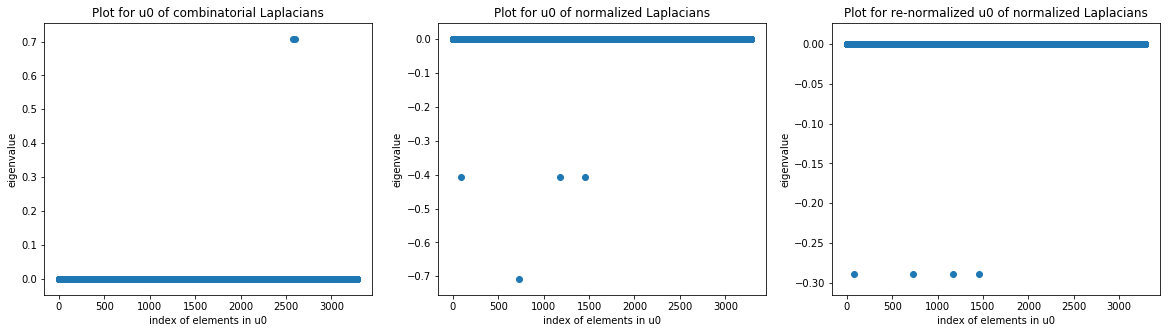

In [20]:
i = 0
fig,ax = plt.subplots(1,3,figsize=(20,5))
ax[0].scatter(x=np.arange(0,n_nodes),y=eigenvectors_comb[:,i])
ax[0].set_title('Plot for u0 of combinatorial Laplacians')
ax[1].scatter(x=np.arange(0,n_nodes),y=eigenvectors_norm[:,i])
ax[1].set_title('Plot for u0 of normalized Laplacians')
ax[2].scatter(x=np.arange(0,n_nodes),y=np.dot(D_root_inv.A,eigenvectors_norm[:,i]))
ax[2].set_title('Plot for re-normalized u0 of normalized Laplacians')
for i in range(len(ax)):
    ax[i].set_xlabel('index of elements in u0')
    ax[i].set_ylabel('eigenvalue')

### Question 6

Look at the spectrum of the Laplacian by plotting the eigenvalues.
Comment on what you observe.

Text(0,0.5,'Eigen value')

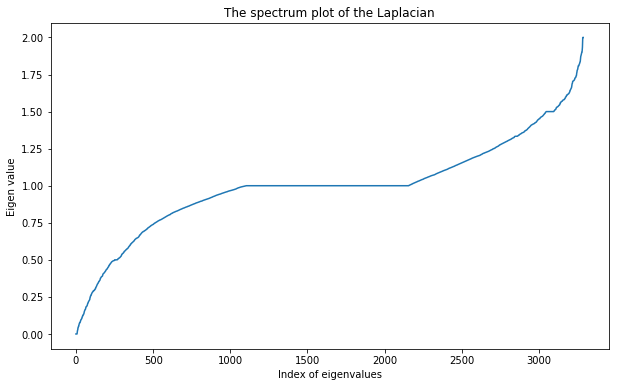

In [17]:
# Your code here.
plt.figure(figsize=(10, 6))
plt.plot(np.sort(eigenvalues))
plt.title('The spectrum plot of the Laplacian')
plt.xlabel('Index of eigenvalues')
plt.ylabel('Eigen value')

**Your answer here.**

The eignvalues of graph is the Fourier spectrum value. In this plot, we can see steep growing gap after k-th eigenvalues, which mean our graph may contain k clusters.

How many connected components are there in your graph? Answer using the eigenvalues only.

In [22]:
# Your code here.
np.where(np.round(eigenvalues,3)==0)

(array([0, 1, 2, 3, 4, 5, 6, 7]),)

Is there an upper bound on the eigenvalues, i.e., what is the largest possible eigenvalue? Answer for both the combinatorial and normalized Laplacians.

**Your answer here.**

There are 8 zero eignvalues in our graph, implying that there are 8 components, which corresponds to previous milestone result.

In [23]:
max_theore = max(np.sum(abs(laplacian_combinatorial.A),axis=0))
print('Theoretical maximum eigenvalue of combinatorial Laplacians is ',max_theore)

Theoretical maximum eigenvalue of combinatorial Laplacians is  3652.0


Theoretically, the possible largest eigenvalue for normalized Laplacian is 2, denoting bipartite graph. 

As for combinatorial Laplacian, according to [Gershgorin circle theorem](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem) the upper bound of maximum eigenvalue should be bounded by the maximum of the largest sum of absolute row, in our case, it is 3652.

In [26]:
max_norm = max(np.round(eigenvalues_norm,3))
print('The maximum eigenvalue of normalized Laplacians is ',max_norm)

The maximum eigenvalue of normalized Laplacians is  2.0


In [24]:
max_comb = max(np.round(eigenvalues_comb,3))
print('The maximum eigenvalue of combinatorial Laplacians is ',max_comb)

The maximum eigenvalue of combinatorial Laplacians is  1839.658


We can check that our eigenvalues are all bellow the theoretical upper bound.

## 3 Laplacian eigenmaps

*Laplacian eigenmaps* is a method to embed a graph $\mathcal{G}$ in a $d$-dimensional Euclidean space.
That is, it associates a vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$.
The graph $\mathcal{G}$ is thus embedded as $Z \in \mathbb{R}^{N \times d}$.

### Question 7

What do we use Laplacian eigenmaps for? (Or more generally, graph embeddings.)

**Your answer here.**

We can reduce the dimension of our data points without losing too much information. The resulting modified data is similar to the original data. 

### Question 8

Embed your graph in $d=2$ dimensions with Laplacian eigenmaps.
Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.

**Recompute** the eigenvectors you need with a partial eigendecomposition method for sparse matrices.
When $k \ll N$ eigenvectors are needed, partial eigendecompositions are much more efficient than complete eigendecompositions.
A partial eigendecomposition scales as $\Omega(k |\mathcal{E}|$), while a complete eigendecomposition costs $\mathcal{O}(N^3)$ operations.

In [21]:
# load the largest component index
idx_largest_com = np.load("idx_largest_component.npy")
laplacian_largest = laplacian[idx_largest_com, :]
laplacian_largest = laplacian_largest[:, idx_largest_com]
n_degree_largest = n_degree[idx_largest_com]

In [22]:
laplacian_largest = np.array(laplacian_largest.todense())

In [23]:
# Your code here.
t1 = time.time();
eigenvalues_laplacian_largest,eigenvectors_laplacian_largest = np.linalg.eigh(laplacian_largest) # full eigenvaluedecomposition
print("full eigendecomposition %1.2fs"%(time.time()-t1))
idx2 = (np.argsort(eigenvalues)[1], np.argsort(eigenvalues)[2]) # find the smallest 2 eigenvalues except 0
Z = eigenvectors_laplacian_largest[:,idx2] # corresponding eigenvectors
Z_n = np.dot(np.diag(n_degree_largest**(-1/2)), Z) # renormalize

full eigendecomposition 2.98s


In [24]:
# recompute eigenvectors
laplacian_largest_sparse = sparse.csr_matrix(laplacian_largest) # convert to csr format
t1 = time.time();
eigenvalues_partial, eigenvectors_partial = sparse.linalg.eigsh(laplacian_largest_sparse, k = 3, which="SA"); # partial eigendecomposition
print("partial (k=3) eigendecomposition %1.2fs"%(time.time()-t1))
Z_recompute = eigenvectors_partial[:,1:3] # corresponding eigenvectors
Z_recompute_n = np.dot(np.diag(n_degree_largest**(-1/2)), Z_recompute) # renormalize

partial (k=3) eigendecomposition 0.05s


Plot the nodes embedded in 2D. Comment on what you see.

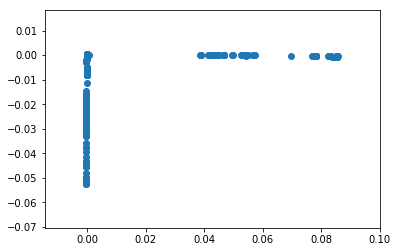

In [25]:
port_name = np.load("port_name.npy")
port_name = port_name[idx_largest_com]
fig, ax = plt.subplots();
ax.scatter(Z_n[:,0], Z_n[:,1]) # renormalize

In [26]:
cluster1 = np.where(Z[:, 0]>0.02)
port_name[cluster1]

array(['SFJ', 'GOH', 'JAV', 'JEG', 'JHS', 'JSU', 'KUS', 'UAK', 'JFR',
       'RKV', 'JQA', 'JUV', 'AGM', 'CNP', 'JJU', 'JNS', 'AEY', 'EGS',
       'IFJ', 'UMD', 'AOQ', 'IUI', 'KGQ', 'KHQ', 'NAQ', 'NSQ', 'TQA',
       'UPK', 'IOQ', 'KUZ', 'SGG', 'TQI', 'OBY', 'JNN', 'LLU', 'QFG',
       'QJH', 'QOQ', 'QUW', 'QFX', 'IKE', 'IOT', 'JUK', 'JUU', 'NIQ',
       'SAE', 'SRK', 'THU', 'QFN', 'XEQ', 'SVR', 'QUV'], dtype=object)

In [27]:
cluster2 = np.where(Z[:, 0]<0.02)
port_name[cluster2]

array(['SCZ', 'HIR', 'ATD', ..., 'YSO', 'WSX', 'LPS'], dtype=object)

**Your answer here.**

We can see two clusters in the nodes embedded in 2D. The upper right cluster is very small regioanl airport mainly in Greenland and some are heliports. The left cluster is remaining airports.Therefore, the left cluster can be some airports which are strongly connected. The upper right cluster can be some very small regional airports(mainly in Greenland) which are connected among them but only a few of them connect to airports in another cluster.

### Question 9

What does the embedding $Z \in \mathbb{R}^{N \times d}$ preserve?

**Your answer here.**

It preserves main features of each node in a d-dimensional feature vector. Similar nodes are clustered in the 𝑑 -dimensional Euclidean space. 

## 2 Spectral clustering

*Spectral clustering* is a method to partition a graph into distinct clusters.
The method associates a feature vector $z_i \in \mathbb{R}^d$ to every node $v_i \in \mathcal{V}$, then runs [$k$-means](https://en.wikipedia.org/wiki/K-means_clustering) in the embedding space $\mathbb{R}^d$ to assign each node $v_i \in \mathcal{V}$ to a cluster $c_j \in \mathcal{C}$, where $k = |\mathcal{C}|$ is the number of desired clusters.

### Question 10

Choose $k$ and $d$. How did you get to those numbers?

**Answer**
If data has k clear clusters, there will be a gap in the Laplacian spectrum after the k-th eigenvalue. So, we choose k such that the gap between $\lambda_k$ and $\lambda_{k+1}$ is distinct. And, we should choose $d = k$ smallest eigen vectors.

### Question 11

1. Embed your graph in $\mathbb{R}^d$ as $Z \in \mathbb{R}^{N \times d}$.
   Try with and without re-normalizing the eigenvectors by the degrees, then keep the one your prefer.
1. If you want $k=2$ clusters, partition with the Fiedler vector. For $k > 2$ clusters, run $k$-means on $Z$. Don't implement $k$-means, use the `KMeans` class imported from scikit-learn.

In [28]:
# Compute partial eigen vectors
eigenvalues_cluster, eigenvectors_cluster = sparse.linalg.eigsh(laplacian_largest_sparse, k = 10, which="SA");

### Discover $k$

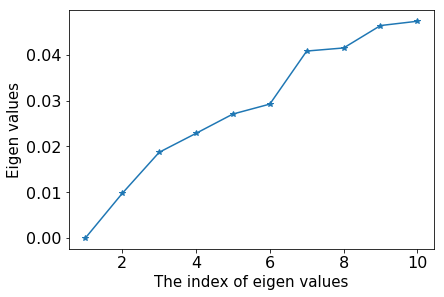

In [29]:
diff = eigenvalues_cluster[1::] - eigenvalues_cluster[0:-1] # Compute first order difference of eigen values
fig1, ax1 = plt.subplots()
ax1.tick_params(labelsize = 16)
fig1.tight_layout()
ax1.set_xlabel('The index of eigen values', fontdict={'fontsize':15})
ax1.set_ylabel('Eigen values',fontdict={'fontsize':15})
ax1.plot(np.arange(eigenvalues_cluster.shape[0]) + 1, eigenvalues_cluster, marker='*')

<BarContainer object of 7 artists>

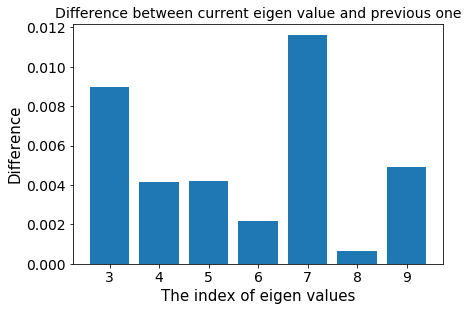

In [30]:
fig2, ax2 = plt.subplots()
ax2.tick_params(labelsize = 14)
fig2.tight_layout()
ax2.set_xlabel('The index of eigen values', fontdict={'fontsize':15})
ax2.set_ylabel('Difference',fontdict={'fontsize':15})
ax2.set_title('Difference between current eigen value and previous one',fontdict={'fontsize':14})
ax2.bar(np.arange(diff.shape[0])[1:-1] + 2, diff[1:-1])

In [31]:
k = 2

**The reason why we choose k = 2:** As we know in spectral clustering, we should choose the k when the gap between $\lambda_{k+1}$ and $\lambda_k$ is relatively large. Here, since the clusters in our graph are not very distinct, it is difficult to find an absolutely good $k$. We have two possible choices: $k=2$ and $k=6$. Considering the graph is the flight route in the world, most of the airports are strongly connected with each other except those who are located in the Arctic area. So, our graph is most likely to have a giant cluster and a small cluster.

### Fiedler vector partition - normalized

In [32]:
eig_vector_kmeans = eigenvectors_cluster[:,0:k] # extract eigen vectors corresponding k smallest eigen values

In [33]:
labels_norm = np.zeros_like(eig_vector_kmeans[:,1])
labels_norm[eig_vector_kmeans[:,1] > 0] = 1 # Normalized partition
print('Labels are',np.unique(labels_norm))

Labels are [0. 1.]


### Fiedler vector partition - unnormalized

In [34]:
D_root_inv_dense = np.array(D_root_inv.todense())
D_root_inv_cluster = D_root_inv_dense[idx_largest_com, :][:, idx_largest_com]

In [35]:
F = D_root_inv_cluster @ eig_vector_kmeans # Compute F vector

In [36]:
labels_unnorm = np.zeros_like(F[:,1])
labels_unnorm[F[:,1] > 0] = 1 # Unnormalized clustering
print('Labels are', np.unique(labels_unnorm))

Labels are [0. 1.]


### Question 12

Use the computed cluster assignment to reorder the adjacency matrix $A$.
What do you expect? What do you observe?

In [37]:
adj_gc = adjacency[idx_largest_com, :][:, idx_largest_com] # largest component adjacency matrix

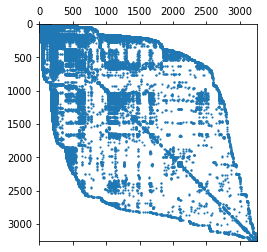

In [38]:
plt.spy(adj_gc, markersize=1) # adjacency matrix - largest component

In [39]:
reorder_idx_norm = np.argsort(labels_norm, kind = 'quicksort') # reorder index
reorder_idx_unnorm = np.argsort(labels_unnorm, kind = 'quicksort')

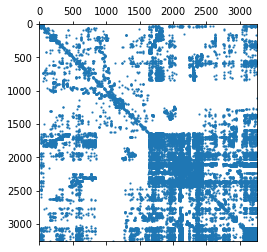

In [40]:
# reorder adjacency matrix with the assignment from normalized clustering
adj_gc_norm = adj_gc[:, reorder_idx_norm][reorder_idx_norm, :]
plt.spy(adj_gc_norm, markersize=1) 
# reorder adjacency matrix with the assignment from unnormalized clustering
adj_gc_unnorm = adj_gc[:, reorder_idx_unnorm][reorder_idx_unnorm, :]

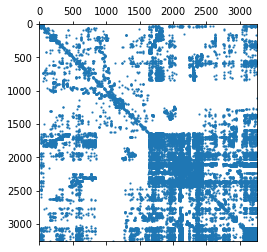

In [41]:
# reorder adjacency matrix with the assignment from unnormalized clustering
adj_gc_unnorm = adj_gc[:, reorder_idx_unnorm][reorder_idx_unnorm, :]
plt.spy(adj_gc_unnorm, markersize=1)

**Answer** Reordering the adjacency matrix by clustering assignment can gather the points around the diagonal on the spy plot and make the points in the other places more sparse because the links in each cluster are more than the inter-clusters links. The points around the diagonal represent the inner links of clusters and the points that are off the diagonal represents inter-cluster links.

From the plots, we can see that many points gather in the left-upper and right-lower spaces. Moreover, points, which stand for inter clusters link, in other spaces are sparse.

### Question 13

If you have ground truth clusters for your dataset, compare the cluster assignment from spectral clustering to the ground truth.
A simple quantitative measure is to compute the percentage of nodes that have been correctly categorized.
If you don't have a ground truth, qualitatively assess the quality of the clustering.

Ground truth clusters are the "real clusters".
For example, the genre of musical tracks in FMA, the category of Wikipedia articles, the spammer status of individuals, etc.
Look for the `labels` in the [dataset descriptions](https://github.com/mdeff/ntds_2018/tree/master/projects/README.md).

In [42]:
# reoder airports name and labels by cluster assignment
port_name_norm = port_name[reorder_idx_norm]
port_name_unnorm = port_name[reorder_idx_unnorm]
labels_norm_ordered = labels_norm[reorder_idx_norm]
labels_unnorm_ordered = labels_unnorm[reorder_idx_unnorm]

In [43]:
airports = pd.read_csv("airports.txt",names = ['Airport_ID','Name','City','Country','IATA','ICAO','Latitude','Longitude',
                                               'Altitude','Timezone','DST','TZ database','Type','Source'])

In [44]:
country_dict_norm = {}
country_dict_unnorm = {}
# initial dictionary to store countries in each cluster
for i in range(k):
    country_dict_norm[i] = []
    country_dict_unnorm[i] = []

In [45]:
# find the country in each cluster
for idx, j in enumerate(labels_norm_ordered):
    try:
        # try to find the corresponding coutry of airports in each cluster
        country_name = airports.Country[airports.IATA == port_name_norm[idx]].values[0]
    except:
        continue
        
    # if the country has not been tag, add it to the list
    if country_name not in country_dict_norm[j]:
        country_dict_norm[j].append(country_name)

In [46]:
country_dict_norm

{0: ['Greenland', 'Iceland', 'Denmark'],
 1: ['Puerto Rico',
  'United States',
  'Peru',
  'Grenada',
  'Dominican Republic',
  'Mexico',
  'Guyana',
  'Saint Kitts and Nevis',
  'Virgin Islands',
  'Cayman Islands',
  'Bahamas',
  'Costa Rica',
  'Solomon Islands',
  'Brazil',
  'Canada',
  'Argentina',
  'Cuba',
  'Paraguay',
  'Bolivia',
  'Haiti',
  'Algeria',
  'France',
  'Greece',
  'Ghana',
  'Indonesia',
  'Australia',
  'Liberia',
  'Poland',
  'Isle of Man',
  'Lithuania',
  'United Kingdom',
  'Ireland',
  'Spain',
  'United Arab Emirates',
  'Morocco',
  'Italy',
  'Western Sahara',
  'Mauritania',
  'Guinea-Bissau',
  'India',
  'South Africa',
  'Tanzania',
  'Sweden',
  'Germany',
  'Iran',
  'Somalia',
  'Gambia',
  'Panama',
  'Honduras',
  'Anguilla',
  'Venezuela',
  'Turks and Caicos Islands',
  'British Virgin Islands',
  'Saint Pierre and Miquelon',
  'Dominica',
  'Madagascar',
  'Mongolia',
  'Switzerland',
  'Austria',
  'Slovakia',
  'Laos',
  'Burma',
  'Vi

In [47]:
# similar procedure with the previous for-loop but using the labels coming from unnormalized partition
for idx, j in enumerate(labels_unnorm_ordered):
    try:
        country_name = airports.Country[airports.IATA == port_name_unnorm[idx]].values[0]
    except:
        continue
    if country_name not in country_dict_unnorm[j]:
        country_dict_unnorm[j].append(country_name)

In [48]:
country_dict_unnorm

{0: ['Greenland', 'Iceland', 'Denmark'],
 1: ['Puerto Rico',
  'United States',
  'Peru',
  'Grenada',
  'Dominican Republic',
  'Mexico',
  'Guyana',
  'Saint Kitts and Nevis',
  'Virgin Islands',
  'Cayman Islands',
  'Bahamas',
  'Costa Rica',
  'Solomon Islands',
  'Brazil',
  'Canada',
  'Argentina',
  'Cuba',
  'Paraguay',
  'Bolivia',
  'Haiti',
  'Algeria',
  'France',
  'Greece',
  'Ghana',
  'Indonesia',
  'Australia',
  'Liberia',
  'Poland',
  'Isle of Man',
  'Lithuania',
  'United Kingdom',
  'Ireland',
  'Spain',
  'United Arab Emirates',
  'Morocco',
  'Italy',
  'Western Sahara',
  'Mauritania',
  'Guinea-Bissau',
  'India',
  'South Africa',
  'Tanzania',
  'Sweden',
  'Germany',
  'Iran',
  'Somalia',
  'Gambia',
  'Panama',
  'Honduras',
  'Anguilla',
  'Venezuela',
  'Turks and Caicos Islands',
  'British Virgin Islands',
  'Saint Pierre and Miquelon',
  'Dominica',
  'Madagascar',
  'Mongolia',
  'Switzerland',
  'Austria',
  'Slovakia',
  'Laos',
  'Burma',
  'Vi

**Answer** From the results, we can see some airports in Denmark, Greenland, Iceland are clustered together. Firstly, these three countries(regions) are close geometrically. Moreover, some of their airports are located in the Arctic Circle. So, it is possible that they have some airports that have few routes to the rest of the regions. For this point, we believe the clustering results are reasonable. From the error rate that we acquire in the next question, the error rate is critically low(0.15%).

### Question 14

Plot the cluster assignment (one color per cluster) on the 2D embedding you computed above with Laplacian eigenmaps.

In [49]:
color = np.random.rand(k, 3)

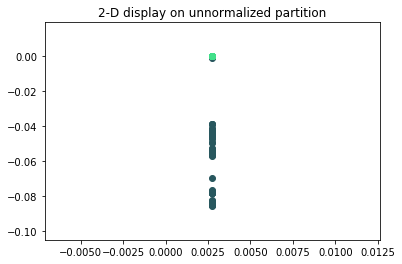

In [50]:
fig_c, ax_c = plt.subplots()
ax_c.set_title('2-D display on unnormalized partition')
for i in range(k):
    ax_c.scatter(F[np.where(labels_unnorm == i),0], F[np.where(labels_unnorm == i),1], c = color[i,:])

In [51]:
error_rate_unnorm = np.sum(F[np.where(labels_unnorm == 0),1] > -0.025) / labels_norm.shape[0]
print('The rate of wrong clustering for unnormalized partition:{:2.2%}'.format(error_rate_unnorm))

The rate of wrong clustering for unnormalized partition:0.15%


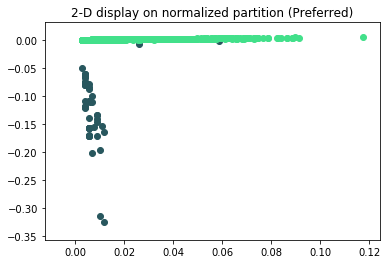

In [52]:
fig_c2, ax_c2 = plt.subplots()
ax_c2.set_title('2-D display on normalized partition (Preferred)')
for i in range(k):
    ax_c2.scatter(eigenvectors_cluster[np.where(labels_norm == i),0], eigenvectors_cluster[np.where(labels_norm == i),1], c = color[i,:])

In [53]:
error_rate_norm = np.sum(eigenvectors_cluster[np.where(labels_norm == 0),1] > -0.025) / labels_norm.shape[0]
print('The rate of wrong clustering for normalized partition:{:2.2%}'.format(error_rate_norm))

The rate of wrong clustering for normalized partition:0.15%


**Comment** In the two plots, we can intuitively discover two clusters. Moreover, two clusters are mostly dyed correctly. However, some points are dyed incorrectly. That means there may exist some errors in our algorithms.

Meanwhile, normalized partition has better effect of display. Hencen, we prefer normalized partition.

### Question 15

Why did we use the eigenvectors of the graph Laplacian as features? Could we use other features for clustering?

**Answer** Each row of eigenvectors(features) stands for whether the point belongs to each component. As we are working on a fully connected component, the assignment is not exactly 1 or 0. So, we utilize k-means to cluster all points. Absolutely, we can also cluster based on the adjacency matrix, and each row is the feature of every node. The number of links between current nodes and other nodes can also represent the connectivity.